# KKBox Music Recommendation Challenge

### 4.3 Handling Missing Values & Feature Engineering

In [ ]:
# import necessary files
import gc
import datetime
import numpy as np
import pandas as pd
import os
import lightgbm as lgb
from sklearn import preprocessing

In [ ]:
# load data

train = pd.read_csv('train_part.csv', nrows=5000000)
print("Read train_part.csv")
train_add = pd.read_csv('train_part_add.csv', nrows=5000000)
print("Read train_part_add.csv")
    
train_y = train['target']
train.drop(['target'], inplace=True, axis=1)

test = pd.read_csv('test.csv', nrows=5000000)
print("Read test.csv")
test_add = pd.read_csv('test_add.csv', nrows=5000000)
print("Read test_add.csv")
test_id = test['id']
test.drop(['id'], inplace=True, axis=1)

Read train_part.csv
Read train_part_add.csv
Read test.csv
Read test_add.csv


In [ ]:
train_add['source'] = train_add['source'].astype('category')
test_add['source'] = test_add['source'].astype('category')

In [ ]:
cols = ['msno_artist_name_prob', 'msno_first_genre_id_prob', 'msno_xxx_prob', \
        'msno_language_prob', 'msno_yy_prob', 'source', 'msno_source_prob', \
        'song_source_system_tab_prob', 'song_source_screen_name_prob', \
        'song_source_type_prob']
        
for col in cols:
    train[col] = train_add[col].values
    test[col] = test_add[col].values

In [ ]:
# merge data

member = pd.read_csv('members_gbdt.csv', nrows=5000000)
print("Read members_gbdt.csv")

train = train.merge(member, on='msno', how='left')
test = test.merge(member, on='msno', how='left')

In [ ]:
member_add = pd.read_csv('members_add.csv', nrows=5000000)
print("Read members_add.csv")

cols = ['msno', 'msno_song_length_mean', 'artist_msno_cnt']
train = train.merge(member_add[cols], on='msno', how='left')
test = test.merge(member_add[cols], on='msno', how='left')

In [ ]:
song = pd.read_csv('songs_gbdt.csv', nrows=5000000)
print("Read songs_gbdt.csv")

In [ ]:
train = train.merge(song, on='song_id', how='left')
test = test.merge(song, on='song_id', how='left')

In [ ]:
cols = song.columns

song.columns = ['before_'+i for i in cols]
train = train.merge(song, on='before_song_id', how='left')
test = test.merge(song, on='before_song_id', how='left')

song.columns = ['after_'+i for i in cols]
train = train.merge(song, on='after_song_id', how='left')
test = test.merge(song, on='after_song_id', how='left')

Additional Features

In [ ]:
# contextual features
train['before_type_same'] = (train['before_source_type'] == train['source_type']) * 1.0
test['before_type_same'] = (test['before_source_type'] == test['source_type']) * 1.0

train['after_type_same'] = (train['after_source_type'] == train['source_type']) * 1.0
test['after_type_same'] = (test['after_source_type'] == test['source_type']) * 1.0

train['before_artist_same'] = (train['before_artist_name'] == train['artist_name']) * 1.0
test['before_artist_same'] = (test['before_artist_name'] == test['artist_name']) * 1.0

train['after_artist_same'] = (train['after_artist_name'] == train['artist_name']) * 1.0
test['after_artist_same'] = (test['after_artist_name'] == test['artist_name']) * 1.0

train['time_spent'] = train['timestamp'] - train['registration_init_time']
test['time_spent'] = test['timestamp'] - test['registration_init_time']

train['time_left'] = train['expiration_date'] - train['timestamp']
test['time_left'] = test['expiration_date'] - test['timestamp']

# user-side features
train['duration'] = train['expiration_date'] - train['registration_init_time']
test['duration'] = test['expiration_date'] - test['registration_init_time']

train['msno_upper_time'] = train['msno_timestamp_mean'] + train['msno_timestamp_std']
test['msno_upper_time'] = test['msno_timestamp_mean'] + test['msno_timestamp_std']

train['msno_lower_time'] = train['msno_timestamp_mean'] - train['msno_timestamp_std']
test['msno_lower_time'] = test['msno_timestamp_mean'] - test['msno_timestamp_std']

# song-side features
train['song_upper_time'] = train['song_timestamp_mean'] + train['song_timestamp_std']
test['song_upper_time'] = test['song_timestamp_mean'] + test['song_timestamp_std']

train['song_lower_time'] = train['song_timestamp_mean'] - train['song_timestamp_std']
test['song_lower_time'] = test['song_timestamp_mean'] - test['song_timestamp_std']

Feature Processing

In [ ]:
# set features to category
embedding_features = ['msno', 'city', 'gender', 'registered_via', \
        'song_id', 'artist_name', 'composer', 'lyricist', 'language', \
        'first_genre_id', 'second_genre_id', 'third_genre_id', 'cc', 'xxx', \
        'isrc_missing', 'source_system_tab', 'source_screen_name', 'source_type']
song_id_feat = ['artist_name', 'composer', 'lyricist', 'language', \
        'first_genre_id', 'second_genre_id', 'third_genre_id', 'cc', 'xxx', \
        'isrc_missing']
embedding_features += ['before_'+i for i in song_id_feat]
embedding_features += ['after_'+i for i in song_id_feat]
embedding_features += ['before_song_id', 'after_song_id', 'before_source_type', \
        'after_source_type', 'before_type_same', 'after_type_same', \
        'before_artist_same', 'after_artist_same']

for feat in embedding_features:
    train[feat] = train[feat].astype('category')
    test[feat] = test[feat].astype('category')

In [ ]:
# feature selection

feat_importance = pd.read_csv('feat_importance_for_test_data.csv')
feature_name = feat_importance['name'].values
feature_importance = feat_importance['importance'].values

drop_col = feature_name[feature_importance<85]
def transfer(x):
    if x == 'msno_source_screen_name_15':
        return 'msno_source_screen_name_17'
    elif  x == 'msno_source_screen_name_16':
        return 'msno_source_screen_name_18'
    elif  x == 'msno_source_screen_name_17':
        return 'msno_source_screen_name_19'
    elif  x == 'msno_source_screen_name_18':
        return 'msno_source_screen_name_20'
    elif  x == 'msno_source_screen_name_19':
        return 'msno_source_screen_name_21'
    elif  x == 'msno_source_screen_name_20':
        return 'msno_source_screen_name_22'
    elif  x == 'msno_source_system_tab_9':
        return 'msno_source_system_tab_0'
    else:
        return x
drop_col = [transfer(i) for i in drop_col]

train.drop(drop_col, axis=1, inplace=True)
test.drop(drop_col, axis=1, inplace=True)

print data information

In [ ]:
# print data information

print('Data preparation done.')
print('\nTraining data shape:')
print(train.shape)
print('\nTesting data shape:')
print(test.shape)
print('\nFeatures involved:')
print(train.columns)

Data preparation done.

Training data shape:
(5000000, 391)

Testing data shape:
(2556790, 391)

Features involved:
Index(['source_system_tab', 'source_screen_name', 'source_type',
       'msno_source_system_tab_prob', 'msno_source_screen_name_prob',
       'msno_source_type_prob', 'song_embeddings_dot', 'artist_embeddings_dot',
       'timestamp', 'msno_till_now_cnt',
       ...
       'after_type_same', 'before_artist_same', 'after_artist_same',
       'time_spent', 'time_left', 'duration', 'msno_upper_time',
       'msno_lower_time', 'song_upper_time', 'song_lower_time'],
      dtype='object', length=391)


#### Checking for missing or null values

In [ ]:
def check_for_missing_values(df):
  '''Function to check missing values in given df'''
  for column in df.columns:
    number_of_nan = df[column].isnull().sum()
    total = df.shape[0]
    percent = number_of_nan / total * 100
    print(column, 'has',  number_of_nan, 'out of total', total, 'values missing, that is, {:.4f}% missing values'.format(percent))

In [ ]:
print("--------------------------------------------------------------------------------------------------------------")
print('\nMissing Value analysis for train data:\n')
check_for_missing_values(train)
print("--------------------------------------------------------------------------------------------------------------")

--------------------------------------------------------------------------------------------------------------

Missing Value analysis for train data:

source_system_tab has 0 out of total 3500000 values missing, that is, 0.0000% missing values
source_screen_name has 0 out of total 3500000 values missing, that is, 0.0000% missing values
source_type has 0 out of total 3500000 values missing, that is, 0.0000% missing values
msno_source_system_tab_prob has 0 out of total 3500000 values missing, that is, 0.0000% missing values
msno_source_screen_name_prob has 0 out of total 3500000 values missing, that is, 0.0000% missing values
msno_source_type_prob has 0 out of total 3500000 values missing, that is, 0.0000% missing values
song_embeddings_dot has 0 out of total 3500000 values missing, that is, 0.0000% missing values
artist_embeddings_dot has 49 out of total 3500000 values missing, that is, 0.0014% missing values
timestamp has 0 out of total 3500000 values missing, that is, 0.0000% missing

There are some features with missing values, which need to be carefully processed. List of features with missing values is as follows:

artist_embeddings_dot, bd, msno_timestamp_std, song_length, artist_song_cnt, composer_song_cnt, lyricist_song_cnt, genre_song_cnt, artist_rec_cnt, composer_rec_cnt, genre_rec_cnt, yy, cc_song_cnt, xxx_song_cnt, yy_song_cnt, xxx_rec_cnt, artist_component_0, artist_component_1, artist_component_2, artist_component_3, artist_component_4, artist_component_5, artist_component_6, artist_component_7, artist_component_8, artist_component_9, artist_component_10, artist_component_11, artist_component_12, artist_component_13, artist_component_14, artist_component_15, song_timestamp_std, before_song_length, before_artist_song_cnt, before_genre_song_cnt, before_artist_rec_cnt, before_genre_rec_cnt, before_artist_component_0, before_artist_component_1, before_artist_component_2, before_artist_component_3, before_artist_component_4, before_artist_component_5, before_artist_component_6, before_artist_component_7, before_artist_component_8, before_artist_component_9, before_artist_component_10, before_artist_component_11, before_artist_component_12, before_artist_component_13, before_artist_component_14, before_artist_component_15, before_song_timestamp_std, after_song_length, after_artist_song_cnt, after_composer_song_cnt, after_genre_song_cnt, after_artist_rec_cnt, after_genre_rec_cnt, after_artist_component_0, after_artist_component_1, after_artist_component_2, after_artist_component_3, after_artist_component_4, after_artist_component_5, after_artist_component_6, after_artist_component_7, after_artist_component_8, after_artist_component_9, after_artist_component_10, after_artist_component_11, after_artist_component_12, after_artist_component_13, after_artist_component_14, after_artist_component_15, after_song_timestamp_std, msno_upper_time, msno_lower_time, song_lower_time 

#### Process missing or null values & standardization or encoding of feature values

In [ ]:
train.dtypes

source_system_tab               category
source_screen_name              category
source_type                     category
msno_source_system_tab_prob      float64
msno_source_screen_name_prob     float64
                                  ...   
duration                         float64
msno_upper_time                  float64
msno_lower_time                  float64
song_upper_time                  float64
song_lower_time                  float64
Length: 391, dtype: object

Label Encoding of categorical features

In [ ]:
train_cat = train.select_dtypes(include=['category']).copy()
train_cat.head()

,source_system_tab,source_screen_name,source_type,before_source_type,after_source_type,source,city,gender,registered_via,artist_name,...,before_language,before_first_genre_id,before_cc,after_language,after_first_genre_id,after_cc,before_type_same,after_type_same,before_artist_same,after_artist_same
0,4,9,5,5,5,346,11,1,3,35218,...,8,116,108,8,116,108,1.0,1.0,1.0,0.0
1,4,9,5,5,5,346,11,1,3,23456,...,8,116,108,0,89,34,1.0,1.0,0.0,0.0
2,4,9,5,5,5,346,11,1,3,30208,...,8,116,108,5,41,102,1.0,1.0,0.0,0.0
3,2,8,7,7,7,199,0,0,2,4822,...,8,27,34,8,116,108,1.0,1.0,0.0,0.0
4,2,8,7,7,7,199,0,0,2,8899,...,8,88,84,8,88,108,1.0,1.0,0.0,0.0


In [ ]:
train_cat.shape

(3500000, 24)

In [ ]:
for column in train_cat:
    train_cat[column] = train_cat[column].astype('object')

In [ ]:
train_cat.dtypes

source_system_tab        object
source_screen_name       object
source_type              object
before_source_type       object
after_source_type        object
source                   object
city                     object
gender                   object
registered_via           object
artist_name              object
language                 object
first_genre_id           object
cc                       object
xxx                      object
before_language          object
before_first_genre_id    object
before_cc                object
after_language           object
after_first_genre_id     object
after_cc                 object
before_type_same         object
after_type_same          object
before_artist_same       object
after_artist_same        object
dtype: object

In [ ]:
train_cat = train_cat.fillna("val_missing")

In [ ]:
for column in train_cat:
    train_cat[column] = train_cat[column].astype('category')

In [ ]:
train_cat.head()

,source_system_tab,source_screen_name,source_type,before_source_type,after_source_type,source,city,gender,registered_via,artist_name,...,before_language,before_first_genre_id,before_cc,after_language,after_first_genre_id,after_cc,before_type_same,after_type_same,before_artist_same,after_artist_same
0,4,9,5,5,5,346,11,1,3,35218,...,8,116,108,8,116,108,1.0,1.0,1.0,0.0
1,4,9,5,5,5,346,11,1,3,23456,...,8,116,108,0,89,34,1.0,1.0,0.0,0.0
2,4,9,5,5,5,346,11,1,3,30208,...,8,116,108,5,41,102,1.0,1.0,0.0,0.0
3,2,8,7,7,7,199,0,0,2,4822,...,8,27,34,8,116,108,1.0,1.0,0.0,0.0
4,2,8,7,7,7,199,0,0,2,8899,...,8,88,84,8,88,108,1.0,1.0,0.0,0.0


Standardizing numerical features

In [ ]:
train_num = train.select_dtypes(include=['int64', 'float64']).copy()
train_num.head()

,msno_source_system_tab_prob,msno_source_screen_name_prob,msno_source_type_prob,song_embeddings_dot,artist_embeddings_dot,timestamp,msno_till_now_cnt,song_till_now_cnt,msno_10_before_cnt,msno_10_after_cnt,...,after_artist_component_15,after_song_timestamp_mean,after_song_timestamp_std,time_spent,time_left,duration,msno_upper_time,msno_lower_time,song_upper_time,song_lower_time
0,0.856164,0.856164,0.200000,0.002684,2.021963,1.471190e+09,0.000000,0.0,0.000000,1.609438,...,-0.001404,1.480697e+09,6.840664e+06,1.649088e+08,3.389760e+07,198806400.0,1.482351e+09,1.473259e+09,NaN,NaN
1,0.856164,0.856164,0.200000,0.003269,0.024372,1.471190e+09,0.693147,0.0,0.693147,1.386294,...,-0.000148,1.471190e+09,NaN,1.649088e+08,3.389760e+07,198806400.0,1.482351e+09,1.473259e+09,1.487538e+09,1.473857e+09
2,0.856164,0.856164,0.200000,0.002684,0.000977,1.471190e+09,1.098612,0.0,1.098612,1.098612,...,-0.008952,1.478073e+09,4.832193e+06,1.649088e+08,3.389759e+07,198806400.0,1.482351e+09,1.473259e+09,NaN,NaN
3,0.167208,0.123534,0.284664,0.748764,0.704682,1.471190e+09,0.693147,0.0,0.693147,1.386294,...,-0.013243,1.478759e+09,4.916908e+06,1.457280e+08,3.597119e+07,181699200.0,1.484458e+09,1.474424e+09,1.483136e+09,1.474279e+09
4,0.167208,0.123534,0.284664,2.161053,2.099312,1.471190e+09,1.098612,0.0,1.098612,1.098612,...,-0.004850,1.480470e+09,4.599311e+06,1.457280e+08,3.597119e+07,181699200.0,1.484458e+09,1.474424e+09,1.483676e+09,1.473842e+09


In [ ]:
train_num.shape

(3500000, 367)

In [ ]:
column_means = train_num.mean()
train_num = train_num.fillna(column_means)

In [ ]:
# https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame

x_ij = train_num.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_ij_scaled = min_max_scaler.fit_transform(x_ij)
train_num = pd.DataFrame(x_ij_scaled, columns=train_num.columns)

In [ ]:
train_num.head()

,msno_source_system_tab_prob,msno_source_screen_name_prob,msno_source_type_prob,song_embeddings_dot,artist_embeddings_dot,timestamp,msno_till_now_cnt,song_till_now_cnt,msno_10_before_cnt,msno_10_after_cnt,...,after_artist_component_15,after_song_timestamp_mean,after_song_timestamp_std,time_spent,time_left,duration,msno_upper_time,msno_lower_time,song_upper_time,song_lower_time
0,0.856112,0.856131,0.199809,0.194018,0.457541,0.000000e+00,0.000000,0.0,0.000000,0.537494,...,0.568099,0.569402,0.570728,0.428202,0.939414,0.866542,0.554341,0.302210,0.596530,0.368271
1,0.856112,0.856131,0.199809,0.194160,0.132119,2.645828e-07,0.086135,0.0,0.289065,0.406598,...,0.572181,0.000000,0.394831,0.428202,0.939414,0.866542,0.554341,0.302210,0.781431,0.347998
2,0.856112,0.856131,0.199809,0.194018,0.128308,5.291658e-07,0.136521,0.0,0.458157,0.237845,...,0.543570,0.412239,0.403157,0.428202,0.939414,0.866542,0.554341,0.302210,0.596530,0.368271
3,0.166905,0.123335,0.284493,0.375275,0.242946,7.937488e-07,0.086135,0.0,0.289065,0.406598,...,0.529625,0.453281,0.410225,0.381068,0.940704,0.857263,0.659089,0.366479,0.569953,0.370562
4,0.166905,0.123335,0.284493,0.718384,0.470141,1.058332e-06,0.136521,0.0,0.458157,0.237845,...,0.556899,0.555806,0.383728,0.381068,0.940704,0.857263,0.659089,0.366479,0.595888,0.347193


Merging both above dataframes

In [ ]:
train = pd.concat([train_cat, train_num], axis=1)
train.head()

,source_system_tab,source_screen_name,source_type,before_source_type,after_source_type,source,city,gender,registered_via,artist_name,...,after_artist_component_15,after_song_timestamp_mean,after_song_timestamp_std,time_spent,time_left,duration,msno_upper_time,msno_lower_time,song_upper_time,song_lower_time
0,4,9,5,5,5,346,11,1,3,35218,...,0.568099,0.569402,0.570728,0.428202,0.939414,0.866542,0.554341,0.302210,0.596530,0.368271
1,4,9,5,5,5,346,11,1,3,23456,...,0.572181,0.000000,0.394831,0.428202,0.939414,0.866542,0.554341,0.302210,0.781431,0.347998
2,4,9,5,5,5,346,11,1,3,30208,...,0.543570,0.412239,0.403157,0.428202,0.939414,0.866542,0.554341,0.302210,0.596530,0.368271
3,2,8,7,7,7,199,0,0,2,4822,...,0.529625,0.453281,0.410225,0.381068,0.940704,0.857263,0.659089,0.366479,0.569953,0.370562
4,2,8,7,7,7,199,0,0,2,8899,...,0.556899,0.555806,0.383728,0.381068,0.940704,0.857263,0.659089,0.366479,0.595888,0.347193


Processing Missing and Null values for test data

In [ ]:
test.dtypes

source_system_tab               category
source_screen_name              category
source_type                     category
msno_source_system_tab_prob      float64
msno_source_screen_name_prob     float64
                                  ...   
duration                         float64
msno_upper_time                  float64
msno_lower_time                  float64
song_upper_time                  float64
song_lower_time                  float64
Length: 391, dtype: object

In [ ]:
test_cat = test.select_dtypes(include=['category']).copy()
test_cat.head()

,source_system_tab,source_screen_name,source_type,before_source_type,after_source_type,source,city,gender,registered_via,artist_name,...,before_language,before_first_genre_id,before_cc,after_language,after_first_genre_id,after_cc,before_type_same,after_type_same,before_artist_same,after_artist_same
0,4,9,4,4,4,345,0,0,2,41079,...,1,40,102,1,41,102,1.0,1.0,0.0,0.0
1,4,9,4,4,4,345,0,0,2,40900,...,1,40,102,1,41,102,1.0,1.0,0.0,0.0
2,1,0,10,10,10,60,0,0,1,36790,...,3,140,55,3,140,55,1.0,1.0,1.0,1.0
3,6,17,8,8,8,483,1,2,3,34786,...,8,27,108,0,72,52,1.0,1.0,0.0,0.0
4,6,17,8,8,8,483,1,2,3,36604,...,8,41,34,5,41,102,1.0,1.0,0.0,0.0


In [ ]:
test_cat.shape

(2556790, 24)

In [ ]:
for column in test_cat:
    test_cat[column] = test_cat[column].astype('object')

In [ ]:
test_cat.dtypes

source_system_tab        object
source_screen_name       object
source_type              object
before_source_type       object
after_source_type        object
source                   object
city                     object
gender                   object
registered_via           object
artist_name              object
language                 object
first_genre_id           object
cc                       object
xxx                      object
before_language          object
before_first_genre_id    object
before_cc                object
after_language           object
after_first_genre_id     object
after_cc                 object
before_type_same         object
after_type_same          object
before_artist_same       object
after_artist_same        object
dtype: object

In [ ]:
test_cat = test_cat.fillna("val_missing")

In [ ]:
for column in test_cat:
    test_cat[column] = test_cat[column].astype('category')

In [ ]:
test_cat.head()

,source_system_tab,source_screen_name,source_type,before_source_type,after_source_type,source,city,gender,registered_via,artist_name,...,before_language,before_first_genre_id,before_cc,after_language,after_first_genre_id,after_cc,before_type_same,after_type_same,before_artist_same,after_artist_same
0,4,9,4,4,4,345,0,0,2,41079,...,1,40,102,1,41,102,1.0,1.0,0.0,0.0
1,4,9,4,4,4,345,0,0,2,40900,...,1,40,102,1,41,102,1.0,1.0,0.0,0.0
2,1,0,10,10,10,60,0,0,1,36790,...,3,140,55,3,140,55,1.0,1.0,1.0,1.0
3,6,17,8,8,8,483,1,2,3,34786,...,8,27,108,0,72,52,1.0,1.0,0.0,0.0
4,6,17,8,8,8,483,1,2,3,36604,...,8,41,34,5,41,102,1.0,1.0,0.0,0.0


Standardizing numerical features

In [ ]:
test_num = test.select_dtypes(include=['int64', 'float64']).copy()
test_num.head()

,msno_source_system_tab_prob,msno_source_screen_name_prob,msno_source_type_prob,song_embeddings_dot,artist_embeddings_dot,timestamp,msno_till_now_cnt,song_till_now_cnt,msno_10_before_cnt,msno_10_after_cnt,...,after_artist_component_15,after_song_timestamp_mean,after_song_timestamp_std,time_spent,time_left,duration,msno_upper_time,msno_lower_time,song_upper_time,song_lower_time
0,1.000000,0.993711,1.000000,0.019850,0.428265,1.484237e+09,4.962845,6.543912,0.000000,1.098612,...,-0.010245,1.478765e+09,4.969881e+06,2.839680e+07,2.145600e+07,49852800.0,1.482923e+09,1.476027e+09,1.484394e+09,1.474916e+09
1,1.000000,0.993711,1.000000,0.316496,1.339412,1.484237e+09,4.969813,8.714568,0.693147,0.693147,...,0.072343,1.479683e+09,4.865995e+06,2.839680e+07,2.145600e+07,49852800.0,1.482923e+09,1.476027e+09,1.483735e+09,1.473795e+09
2,0.834586,0.218045,0.052632,0.001638,0.121210,1.484237e+09,4.890349,1.791759,0.000000,0.693147,...,-0.000267,1.481466e+09,3.795670e+06,4.896005e+06,-4.291205e+06,604800.0,1.481240e+09,1.474618e+09,1.485262e+09,1.477670e+09
3,0.762918,0.762918,0.762918,0.016641,0.115176,1.484237e+09,5.963579,3.465736,0.000000,1.945910,...,-0.000617,1.480925e+09,4.498435e+06,2.989152e+08,9.273594e+06,308188800.0,1.486001e+09,1.479821e+09,1.485508e+09,1.474898e+09
4,0.762918,0.762918,0.762918,0.005458,0.021629,1.484237e+09,5.966147,1.791759,0.693147,1.791759,...,0.017260,1.480866e+09,4.738176e+06,2.989152e+08,9.273592e+06,308188800.0,1.486001e+09,1.479821e+09,1.485423e+09,1.476426e+09


In [ ]:
test_num.shape

(2556790, 367)

In [ ]:
column_means = test_num.mean()
test_num = test_num.fillna(column_means)

In [ ]:
# https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame

x_ij = test_num.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_ij_scaled = min_max_scaler.fit_transform(x_ij)
test_num = pd.DataFrame(x_ij_scaled, columns=test_num.columns)

In [ ]:
test_num.head()

,msno_source_system_tab_prob,msno_source_screen_name_prob,msno_source_type_prob,song_embeddings_dot,artist_embeddings_dot,timestamp,msno_till_now_cnt,song_till_now_cnt,msno_10_before_cnt,msno_10_after_cnt,...,after_artist_component_15,after_song_timestamp_mean,after_song_timestamp_std,time_spent,time_left,duration,msno_upper_time,msno_lower_time,song_upper_time,song_lower_time
0,1.000000,0.993710,1.000000,0.246799,0.139133,0.000000e+00,0.553034,0.675917,0.000000,0.237845,...,0.539367,0.408049,0.414643,0.073393,0.800859,0.112061,0.509071,0.403745,0.552632,0.363013
1,1.000000,0.993710,1.000000,0.338238,0.298443,3.911156e-07,0.553810,0.900123,0.289065,0.000000,...,0.807755,0.465563,0.405975,0.073393,0.800859,0.112061,0.509071,0.403745,0.514301,0.309277
2,0.834534,0.217871,0.052338,0.241186,0.085445,7.822311e-07,0.544955,0.185070,0.000000,0.000000,...,0.571794,0.577315,0.316676,0.016020,0.747913,0.001359,0.410597,0.334755,0.603070,0.495073
3,0.762843,0.762865,0.762844,0.245810,0.084390,1.173347e-06,0.664550,0.357974,0.000000,0.734867,...,0.570656,0.543387,0.375309,0.733809,0.775807,0.692756,0.689139,0.589432,0.617362,0.362160
4,0.762843,0.762865,0.762844,0.242363,0.068034,1.564462e-06,0.664836,0.185070,0.289065,0.644442,...,0.628750,0.539732,0.395311,0.733809,0.775807,0.692756,0.689139,0.589432,0.612455,0.435421


Merging both above dataframes

In [ ]:
test = pd.concat([test_cat, test_num], axis=1)
test.head()

,source_system_tab,source_screen_name,source_type,before_source_type,after_source_type,source,city,gender,registered_via,artist_name,...,after_artist_component_15,after_song_timestamp_mean,after_song_timestamp_std,time_spent,time_left,duration,msno_upper_time,msno_lower_time,song_upper_time,song_lower_time
0,4,9,4,4,4,345,0,0,2,41079,...,0.539367,0.408049,0.414643,0.073393,0.800859,0.112061,0.509071,0.403745,0.552632,0.363013
1,4,9,4,4,4,345,0,0,2,40900,...,0.807755,0.465563,0.405975,0.073393,0.800859,0.112061,0.509071,0.403745,0.514301,0.309277
2,1,0,10,10,10,60,0,0,1,36790,...,0.571794,0.577315,0.316676,0.016020,0.747913,0.001359,0.410597,0.334755,0.603070,0.495073
3,6,17,8,8,8,483,1,2,3,34786,...,0.570656,0.543387,0.375309,0.733809,0.775807,0.692756,0.689139,0.589432,0.617362,0.362160
4,6,17,8,8,8,483,1,2,3,36604,...,0.628750,0.539732,0.395311,0.733809,0.775807,0.692756,0.689139,0.589432,0.612455,0.435421


Saving dataframes

In [ ]:
# saving the train dataframe...

train.to_csv('train_saved.csv', index=False)

In [ ]:
# saving y values...

train_y.to_csv('train_y_saved.csv', index=False)

In [ ]:
# saving the train dataframe...

test.to_csv('test_saved.csv', index=False)

In [ ]:
# savig test id values
test_id.to_csv('test_id_saved.csv', index=False)

In [ ]:
# Loading back the saved data...

train = pd.read_csv("train_saved.csv")
train_y = pd.read_csv("train_y_saved.csv")

In [ ]:
my_train = train[:3000000] # 3M data points
my_val = train[3000000:]

my_train_y = train_y[:3000000]
my_val_y = train_y[3000000:]

In [ ]:
print(my_train.shape)
print(my_val.shape)
print(len(my_train_y))
print(len(my_val_y))

(3000000, 391)
(500000, 391)
3000000
500000


In [ ]:
# saving the split data

my_train.to_csv('my_train.csv', index=False)
my_val.to_csv('my_val.csv', index=False)

Start loading from here

In [ ]:
# Loading back the saved data...

my_train = pd.read_csv("my_train.csv")
print("Read my_train.csv")
train_y = pd.read_csv("train_y_saved.csv")
print("Read train_y_saved.csv")
my_val = pd.read_csv("my_val.csv")
print("Read my_val.csv")

test = pd.read_csv('test_saved.csv', nrows=3500000)
print("Read test_saved.csv")

test_id = pd.read_csv('test_id_saved.csv', nrows=3500000)
print("Read test_id_saved.csv")

my_train_y = train_y[:3000000]
my_val_y = train_y[3000000:]

Read my_train.csv
Read train_y_saved.csv
Read my_val.csv
Read test_saved.csv
Read test_id_saved.csv


In [ ]:
print(my_train.shape)
print(len(my_train_y))
print(my_val.shape)
print(len(my_val_y))
print(test.shape)
print(len(test_id))

(3000000, 391)
3000000
(500000, 391)
500000
(2556790, 391)
2556790


# 5. Building Models

In [ ]:
conda install -c anaconda py-xgboost

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [ ]:
# plot Feature Importance for a given model

def plot_FI(df, features, importance, model):
    '''Function to plot Feature Imporatance'''

    plt.figure(figsize=(20, 15))
    sns.set(font_scale=2)
    sns.set(style="whitegrid")
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Importance', fontsize=15)
    plt.xticks(rotation='90')
    ax = sns.barplot(x=features, y=importance, data=df)
    plt.title('Feature Importance for {model} model'.format(model=model), fontsize=30)
    plt.tight_layout()

## 5. 1. Logistic Regression

In [ ]:
from sklearn.linear_model import SGDClassifier

Hyperparameter Tuning For Logistic Regression

In [ ]:
from prettytable import PrettyTable

print("Hyperparameters tried & results achieved for Logistic Regression")
x = PrettyTable()
x.field_names = ["Sr. No.", "Learning Rate", "epsilon", "eta0", "penalty", "power_t", "max_iter", "tol", "Kaggle Score"]
x.add_row([1. , 0.0001, 0.1, 0.0, "L1", 0.5, 1250, 0.001, 0.51240])
x.add_row([2. , 0.001, 0.1, 0.0, "L1", 0.5, 1250, 0.001, 0.57383])
x.add_row([3. , 0.01, 0.1, 0.0, "L1", 0.5, 1250, 0.001, 0.51206])
x.add_row([4. , 0.1, 0.1, 0.0, "L1", 0.5, 1250, 0.001, 0.53598])
x.add_row([5. , 0.0001, 0.1, 0.0, "L2", 0.5, 1250, 0.001, 0.52577])
print(x)

Hyperparameters tried & results achieved for Logistic Regression
+---------+---------------+---------+------+---------+---------+----------+-------+--------------+
| Sr. No. | Learning Rate | epsilon | eta0 | penalty | power_t | max_iter |  tol  | Kaggle Score |
+---------+---------------+---------+------+---------+---------+----------+-------+--------------+
|   1.0   |     0.0001    |   0.1   | 0.0  |    L1   |   0.5   |   1250   | 0.001 |    0.5124    |
|   2.0   |     0.001     |   0.1   | 0.0  |    L1   |   0.5   |   1250   | 0.001 |   0.57383    |
|   3.0   |      0.01     |   0.1   | 0.0  |    L1   |   0.5   |   1250   | 0.001 |   0.51206    |
|   4.0   |      0.1      |   0.1   | 0.0  |    L1   |   0.5   |   1250   | 0.001 |   0.53598    |
|   5.0   |     0.0001    |   0.1   | 0.0  |    L2   |   0.5   |   1250   | 0.001 |   0.52577    |
+---------+---------------+---------+------+---------+---------+----------+-------+--------------+


Training Logistic Regression with best parameters

In [ ]:
# Training Logistic regression with best parameters
lr = SGDClassifier(alpha=0.001, average=False, class_weight='balanced',
                   early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
                   l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1250,
                   n_iter_no_change=5, n_jobs=-1, penalty='l1', power_t=0.5,
                   random_state=23, shuffle=True, tol=0.001, validation_fraction=0.1,
                   verbose=0, warm_start=False)

lr.fit(my_train, my_train_y.values.ravel())

print('Train AUC = ', lr.score(my_train, my_train_y.values.ravel()))
print('Val AUC = ', lr.score(my_val, my_val_y.values.ravel()))

Train AUC =  0.6622763333333334
Val AUC =  0.610182


In [ ]:
test_pred_lr = lr.predict(test)

test_sub_lr = pd.DataFrame({'id': test_id.values.ravel(), 'target': test_pred_lr})
test_sub_lr.to_csv('lr_001l1.csv.gz', index=False, compression='gzip')

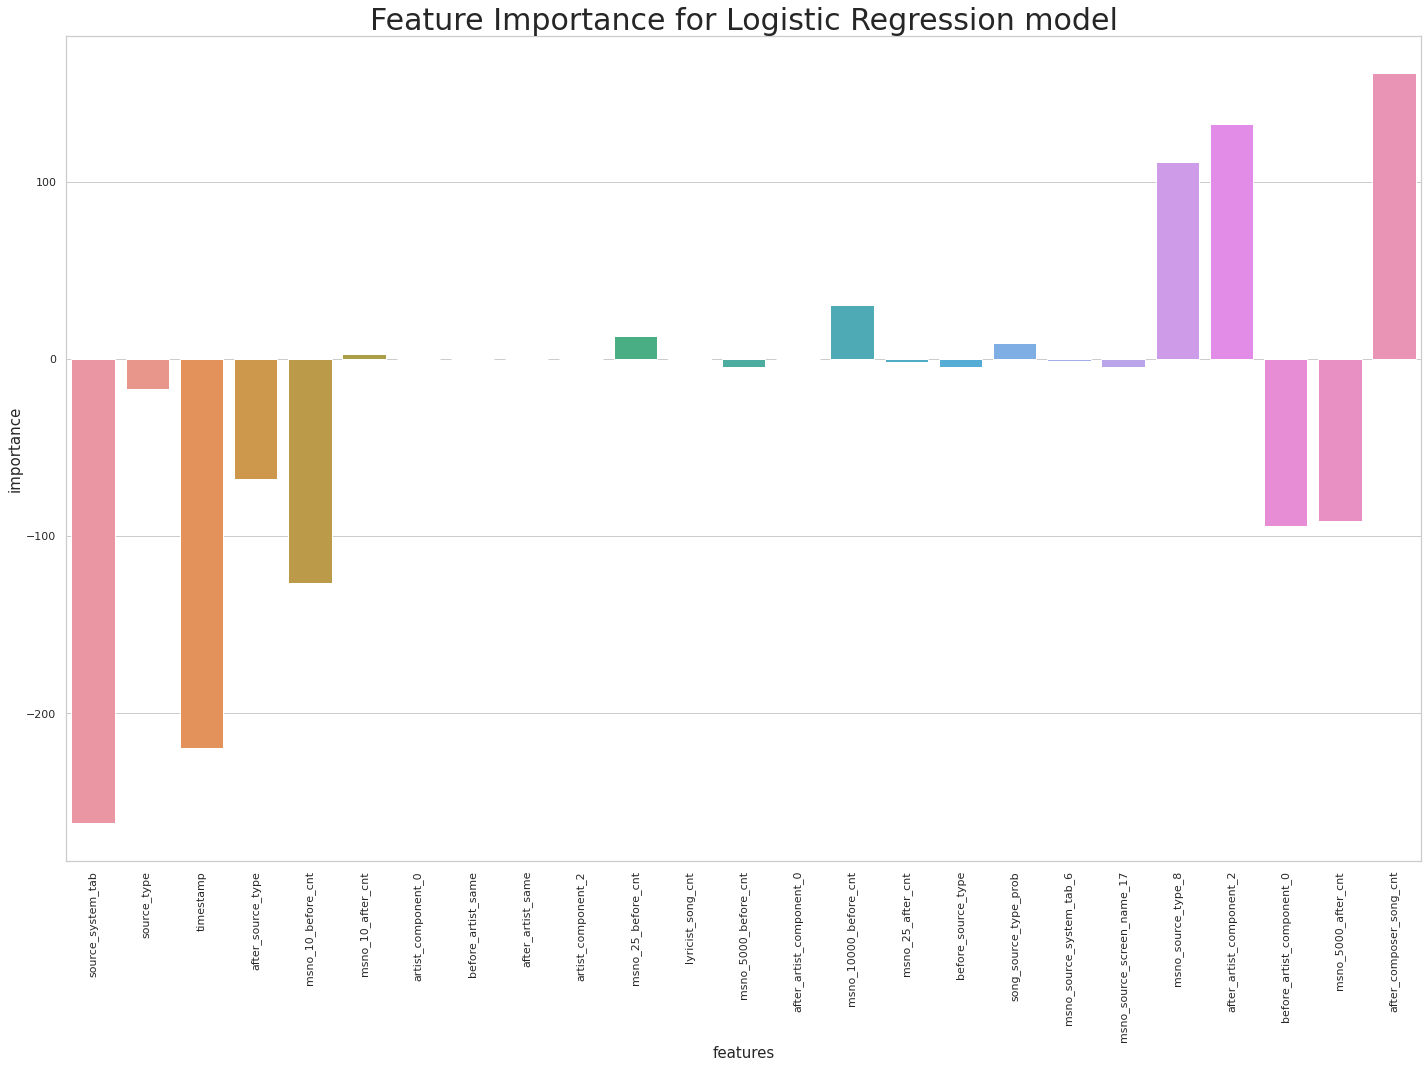

In [ ]:
# Feature Importance for Logistic Regression

# preparing dataframe for plotting feature importance
sorted_indices_lr = lr.coef_[0].argsort()
features = my_train.columns[sorted_indices_lr]
lr_fea_imp_1 = pd.DataFrame({
    'features' : features,
    'importance' : lr.coef_[0]
})

# selecting top 25 most important features
lr_fea_imp = lr_fea_imp_1.iloc[:25]
# plot feature importance for LR
plot_FI(lr_fea_imp, 'features', 'importance', 'Logistic Regression')

## 5. 2. LightGBM

In [ ]:
import pickle
import joblib

In [ ]:
#!pip3 install lightgbm

Hyperparameter Tuning For LightGBM

In [ ]:
from prettytable import PrettyTable

print("Hyperparameters tried & results achieved for LightGBM")
x = PrettyTable()
x.field_names = ["Sr. No.", "learning_rate", "num_leaves", "max_depth", "feature_fraction", "bagging_fraction", "num_round", "Kaggle Score"]
x.add_row([1. , 0.05, 99, 12, 0.6890, 0.9092, 9550, 0.71634])
x.add_row([2. , 0.4, 111, 14, 0.6890, 0.9092, 2650, 0.71649])
x.add_row([3. , 0.1, 99, 10, 0.6866, 0.9054, 4750, 0.72755])
print(x)

Hyperparameters tried & results achieved for LightGBM
+---------+---------------+------------+-----------+------------------+------------------+-----------+--------------+
| Sr. No. | learning_rate | num_leaves | max_depth | feature_fraction | bagging_fraction | num_round | Kaggle Score |
+---------+---------------+------------+-----------+------------------+------------------+-----------+--------------+
|   1.0   |      0.05     |     99     |     12    |      0.689       |      0.9092      |    9550   |   0.71634    |
|   2.0   |      0.4      |    111     |     14    |      0.689       |      0.9092      |    2650   |   0.71649    |
|   3.0   |      0.1      |     99     |     10    |      0.6866      |      0.9054      |    4750   |   0.72755    |
+---------+---------------+------------+-----------+------------------+------------------+-----------+--------------+


Training LightGBM with best parameters

In [ ]:
train_data = lgb.Dataset(train, label=train_y, free_raw_data=True)

Total Rounds: 4750
Training the model...
[100]	training's binary_logloss: 0.548	training's auc: 0.795364
[200]	training's binary_logloss: 0.53498	training's auc: 0.806097
[300]	training's binary_logloss: 0.52687	training's auc: 0.813007
[400]	training's binary_logloss: 0.520698	training's auc: 0.818242
[500]	training's binary_logloss: 0.515483	training's auc: 0.822643
[600]	training's binary_logloss: 0.510991	training's auc: 0.826416
[700]	training's binary_logloss: 0.506977	training's auc: 0.82977
[800]	training's binary_logloss: 0.503287	training's auc: 0.832796
[900]	training's binary_logloss: 0.500015	training's auc: 0.835452
[1000]	training's binary_logloss: 0.49705	training's auc: 0.837832
[1100]	training's binary_logloss: 0.494233	training's auc: 0.840096
[1200]	training's binary_logloss: 0.491559	training's auc: 0.84221
[1300]	training's binary_logloss: 0.489122	training's auc: 0.844138
[1400]	training's binary_logloss: 0.48677	training's auc: 0.845972
[1500]	training's binary_

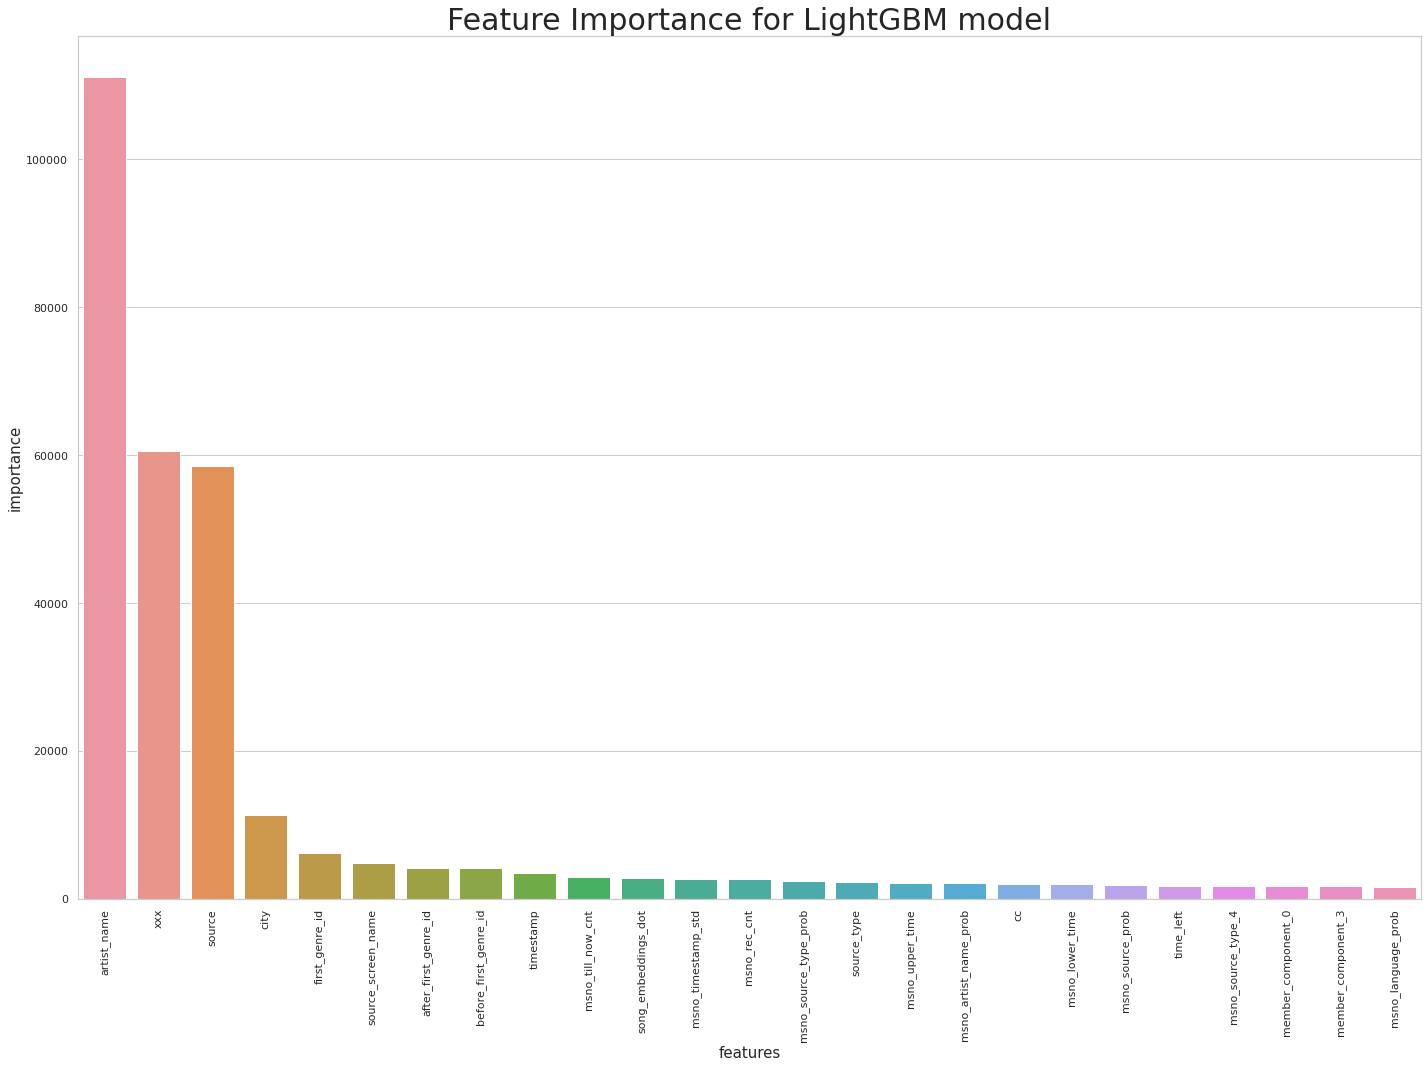

In [ ]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['binary_logloss', 'auc'], 

    'learning_rate': 0.1,

    'num_leaves': 99,
    'max_depth': 10,
    'min_data_in_leaf': 1306,

    'feature_fraction': 0.6866,
    'bagging_fraction': 0.9054,
    'bagging_freq': 1,

    'lambda_l1': 6.37,
    'lambda_l2': 65200,
    'min_gain_to_split': 0,
    'min_sum_hessian_in_leaf': 0.1,

    'num_threads': 16,
    'verbose': -1,
    'is_training_metric': 'True'
}

num_round = 4750
print('Total Rounds: %d'%num_round)

print('Training the model...')
gbm = lgb.train(params, train_data, num_round, valid_sets=train_data, verbose_eval=100)
print('Done')

# saving the model...
joblib.dump(gbm, 'gbm.pkl')

feature_importance = pd.DataFrame({'name':gbm.feature_name(), 'importance':gbm.feature_importance()}).sort_values(by='importance', ascending=False)
print("Feature Importance: ", feature_importance)
feature_importance.to_csv('feat_importance_for_test_data.csv', index=False)

# preparing dataframe for plotting feature importance
gbm_fea_imp_1 = pd.DataFrame({
    'features' : gbm.feature_name(),
    'importance' : gbm.feature_importance()
}).sort_values(by='importance', ascending=False)
    
# selecting top 25 most important features
gbm_fea_imp = gbm_fea_imp_1.iloc[:25]

flag = np.random.randint(0, 65536)    

# predict on test data
test_pred = gbm.predict(test)

test_sub = pd.DataFrame({'id': test_id, 'target': test_pred})
test_sub.to_csv('lgb_%.5f_%d.csv.gz'%(0.1, flag), index=False, compression='gzip')

lst_name = list(feature_importance["name"])
lst_fi = list(feature_importance["importance"])

# plot Feature Importance
plot_FI(gbm_fea_imp, 'features', 'importance', 'LightGBM')

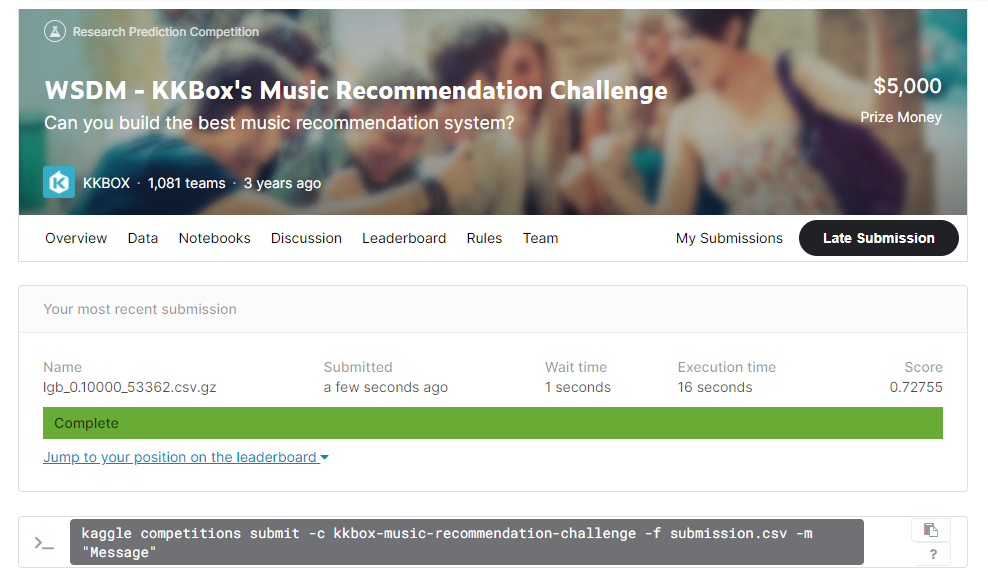

In [ ]:
from IPython.display import Image
Image('KaggleKKBoxScore.PNG')

*Secured a rank in **Top 1%** on the Kaggle Leaderboard for this competition.*

*A brief overview of the Exploratory Data Analysis can be found at https://share.streamlit.io/learner-subodh/streamlit-example/kkbox.py*